In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

Dataset 1: movie ranking. Task: matrix completion.

In [63]:
## import data
data = pd.read_csv('MovRankData.csv')
A = data.to_numpy()[:,1:].astype('float')
print(A.shape)

(60, 20)


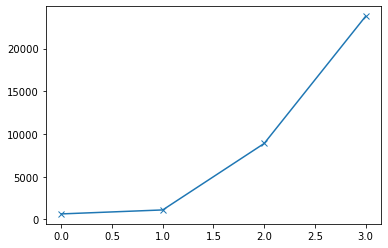

In [95]:
# low-rank factorization
def lrfac(A,lam, k=10):
    # A is the matrix
    # lam is the regularization parameter
    n, d = A.shape
    # filled A with zeros in empty entries
    A_p = np.nan_to_num(A,nan=0)
    Omg = np.isnan(A) # n by d
    # initialize
    X, Y = np.ones((n,k)), np.ones((d,k)) ########
    # find argmin
    iter_ = 0
    while iter_<100:
        # keep Y, update X
        Y_p = Y.copy()
        Y_p[Omg.T[:,:k]] = 0  
        denom = np.sum(Y_p**2, axis=0)-lam
        X = np.divide(np.matmul(A_p,Y).T, denom.reshape(-1,1)).T
        # keep X, update Y
        X_p = X.copy()
        X_p[Omg[:,:k]] = 0
        denom = np.sum(X_p**2, axis=0)-lam
        Y = np.divide(np.matmul(A_p.T,X).T, denom.reshape(-1,1)).T
        
        iter_ += 1
    return X,Y   # X@Y.T

# experiment with different lambda
lrerr = []
mask = np.ones(A.shape)
mask[np.isnan(A)] = 0
A_p = np.nan_to_num(A,nan=0)
for lam in [0.1,1,3,10]:
    X,Y = lrfac(A,lam)
    lrerr.append(linalg.norm(A_p-X@Y.T*mask))
plt.plot(lrerr,marker='x')    
# most reasonable result

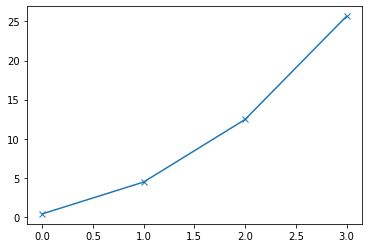

In [83]:
# nuclear norm
def Nnfac(A, lam):
    n, d = A.shape
    Omg = np.isnan(A)
    # initialize
    M = np.zeros((n,d))
    iter_ = 0
    while iter_<100:
        Aux = A - M
        Aux[Omg] = 0
        U, Sig, Vh = linalg.svd(M+Aux,compute_uv=True,full_matrices=False)
        M = U@np.diag(np.maximum(Sig-lam,0))@Vh
        iter_ += 1
    return M

# experiment with different lambda
ncerr = []
mask = np.ones(A.shape)
mask[np.isnan(A)] = 0
A_p = np.nan_to_num(A,nan=0)
for lam in [0.1,1,3,10]:
    M = Nnfac(A,lam)
    ncerr.append(linalg.norm(A_p-M*mask))
plt.plot(ncerr,marker='x')

Dataset 1: movie rankings. Task: NMF.

In [110]:
# projected gradient descend
def PGDNMF(A,alpha,k):
    n,d = A.shape
    # initialize
    W = np.ones((n,k))
    H = np.ones((k,d))
    it = 0
    while it<1000:
        R = A - W@H
        if linalg.norm(R)<0.001:
            break
        W = np.maximum(0, W + alpha*R@H.T)
        H = np.maximum(0, H + alpha*W.T@R)
        it += 1
return W,H

def LSNMF(A,k):
    n,d = A.shape
    # initialize
    W = np.ones((n,k))
    H = np.ones((k,d))
    it = 0
    while it<1000:
        W = (W*A@H.T)/(W@H@H.T)
        H = (H*W.T@A)/(W.T@W@H)
        if linalg.norm(A-W@H)<0.001:
            break
return W,H


def kmeans(A,k, iter_max=1000):
    n,m = A.shape
    idx = np.random.choice(n, k, replace=False)
    cen = A[idx, :] 
    dist = np.zeros((n,k))
    for i in range(k):
        dist[:,k] = np.sum((cen[i,:]-A)**2,axis=1)

    points = np.array([np.argmin(row) for row in dist]) 
    
    for _ in range(iter_max): 
        cen = []
        for idx in range(k):
            temp_cent = A[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
        cen = np.vstack(cen)
        dist = np.zeros((n,k))
        for i in range(k):
            dist[:,k] = np.sum((cen[i,:]-A)**2,axis=1)
        points = np.array([np.argmin(row) for row in dist])
         
    return points 

SyntaxError: 'return' outside function (<ipython-input-110-290d90bb9e38>, line 15)

Dataset 2: text documents. Task: CUR factorization.

In [99]:
## import data
from scipy.io import loadmat
M = np.array(loadmat('proj2_M.mat')['M']).astype(int)
Mcounts = np.array(loadmat('proj2_Mcounts.mat')['Mcounts']).astype(int)
y = np.array(loadmat('proj2_y.mat')['y'])
words = np.array(loadmat('proj2_words.mat')['words'])

In [3]:
print(M.shape)
print(Mcounts.shape)
print(y.shape)
print(words.shape)

(139, 18446)
(139, 18446)
(139, 1)
(1, 18446)


In [40]:
## CUR factorization
def colSel(A,k,eps=1):
    m,n = A.shape
    # compute top k right sigular vectors
    u,s,vT = linalg.svd(A, compute_uv=True)
    v = vT.T
    pis = np.sum(v[:,:k]**2, axis=1)/k
    # keep j-th column with probability 
    c = k*np.log(k)/(eps*eps) 
    prob = np.minimum(1,c*pis)
    ind = (np.random.rand(n)<prob)
    if np.sum(ind)==0:
        ind = np.argmax(pis)
    return A[:,ind],pis
    
def CUR(A,k,c_eps=1,r_eps=1):
    # A matrix m by n
    # k integer less than m
    C,c_pis = colSel(A, k, c_eps)
    RT,r_pis = colSel(A.T, k, r_eps)
    U = linalg.pinv(C) @A @(linalg.pinv(RT.T))
    return C, U, RT.T, c_pis, r_pis

def CURsim(A,v_c,v_r,k,c_eps,r_eps):
    m,n = A.shape
    
    c_pis = np.sum(v_c[:,:k]**2, axis=1)/k
    # keep j-th column with probability 
    c = k*np.log(k)/(c_eps*c_eps) 
    prob = np.minimum(1,c*c_pis)
    ind = (np.random.rand(n)<prob)
    C = A[:,ind]
    
    r_pis = np.sum(v_r[:,:k]**2, axis=1)/k
    # keep j-th column with probability 
    r = k*np.log(k)/(r_eps*r_eps) 
    prob = np.minimum(1,r*r_pis)
    ind = (np.random.rand(m)<prob)
    R = (A.T)[:,ind].T
    
    U = linalg.pinv(C) @A @(linalg.pinv(R))
    return C, U, R

k=2:
and
the
for
with
this
k=3:
and
the
for
with
are
k=4:
and
the
for
with
gif
k=5:
and
the
for
with
gif
k=6:
and
the
for
with
contact
k=7:
and
the
for
gif
with
k=8:
and
the
for
gif
contact
k=9:
gif
and
the
for
contact
k=10:
gif
and
the
for
with
k=11:
gif
and
the
for
evansville
k=12:
gif
and
the
for
evansville
k=13:
gif
and
the
for
contact
k=14:
gif
and
the
for
jpg
k=15:
gif
and
the
for
jpg
k=16:
gif
and
the
for
evansville
k=17:
gif
and
the
for
evansville
k=18:
gif
and
the
for
evansville
k=19:
gif
and
the
for
evansville
k=20:
gif
and
the
for
evansville


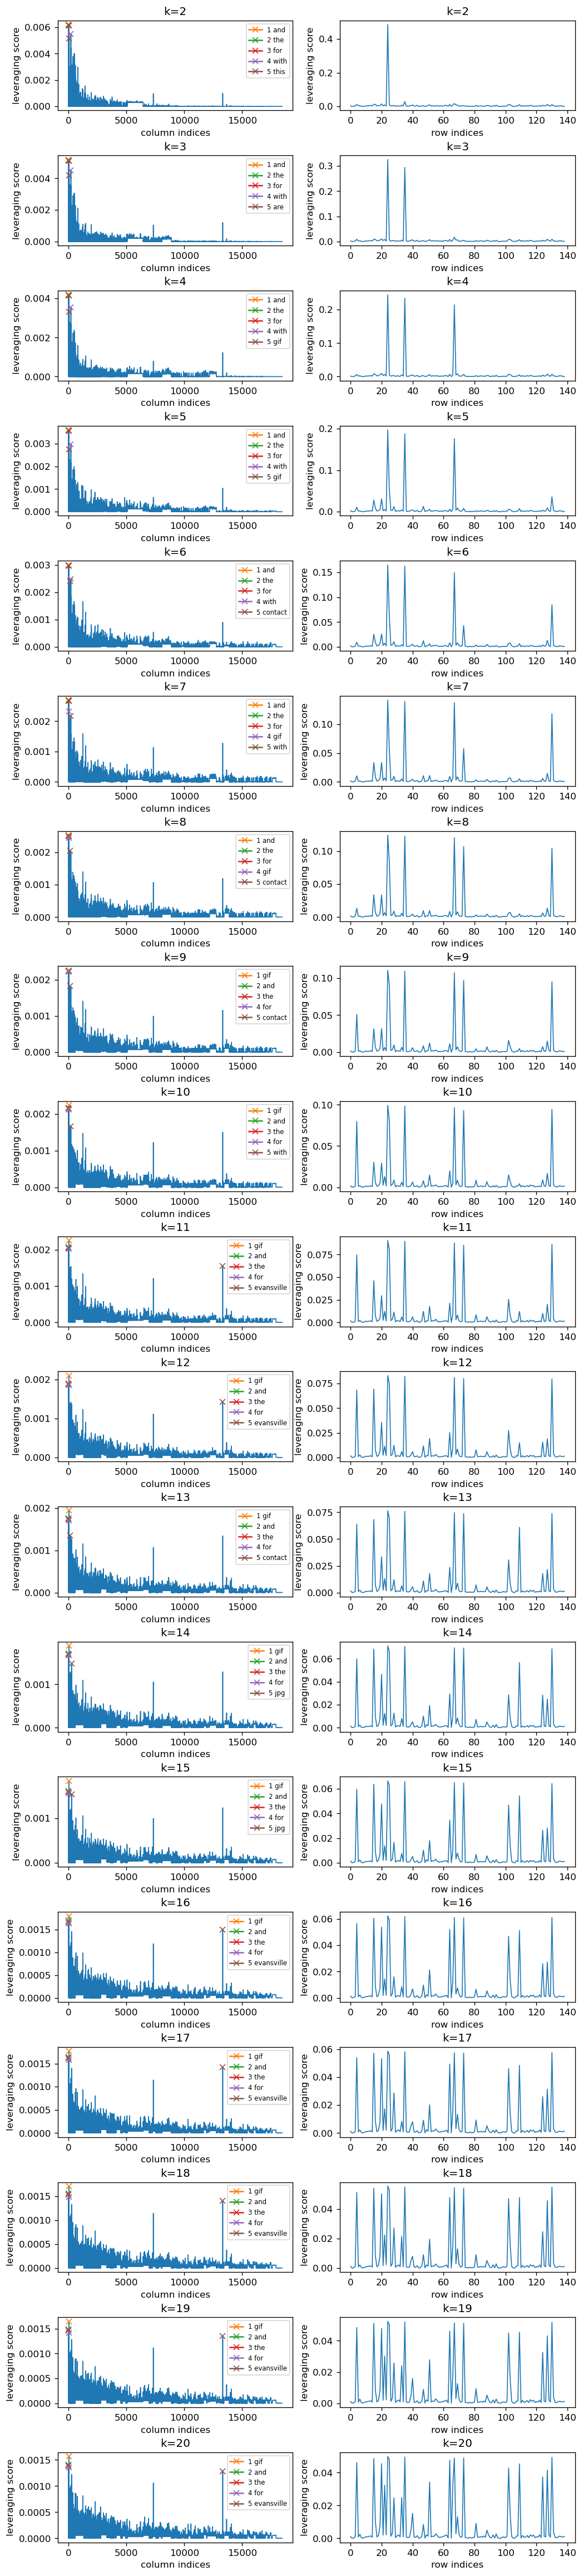

In [5]:
A = M.copy()
m,n = A.shape

# epss = np.sqrt(20*np.log(20)/np.array([10,20,40,60]))
epss=[1]

fig, ax = plt.subplots(19,2,figsize=(10,50),dpi=120)
plt.subplots_adjust(wspace=0.2,hspace=0.5)
for i in range(len(epss)):
    c_eps = epss[i]
    r_eps = epss[i]
    for k in range(2,21): #2-20
        C,U,R,c_pis,r_pis = CUR(A,k,c_eps,r_eps)
        sorted_ind = np.argsort(-c_pis)[:5]
        # print out words with high leveraging scores
        print('k=%d:'%k)
        # plot leveraging scores vs indices
#         ax[0,k-2].vlines(x=range(1,n+1),ymin=0,ymax=c_pis,label='k=%d'%k)
#         ax[1,k-2].vlines(x=range(1,m+1),ymin=0,ymax=r_pis,label='k=%d'%k)
        ax[k-2,0].plot(c_pis,linewidth=1)
        for j in range(5):
            indd = sorted_ind[j]
            print(words[0,indd][0])
            ax[k-2,0].plot(indd,c_pis[indd],marker='x',label='%d '%(j+1)+words[0,indd][0])
        ax[k-2,1].plot(r_pis,linewidth=1)
        ax[k-2,0].legend(fontsize=7)
        ax[k-2,0].set_xlabel('column indices')
        ax[k-2,0].set_ylabel('leveraging score')
        ax[k-2,0].set_title('k=%d'%k)

        ax[k-2,1].set_xlabel('row indices')
        ax[k-2,1].set_ylabel('leveraging score')
        ax[k-2,1].set_title('k=%d'%k)

plt.show()            

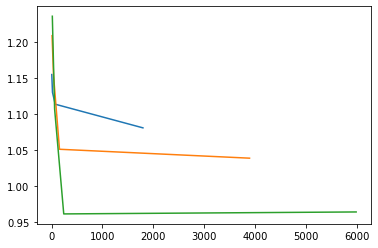

In [45]:
A = M.copy() # Mcounts
c_epss = [0.1,0.5,1,2]
r_epss = [1]
ks = [6,13,20]
ratios = np.zeros((3,len(c_epss),len(r_epss)))
errs = np.zeros(19)
U0, S, Vh = linalg.svd(A,compute_uv=True,full_matrices=False)

v_c = linalg.svd(A,compute_uv=True)[2]
v_r = linalg.svd(A.T,compute_uv=True)[2]

for l in range(3):
    k = ks[l]
    Mk = U0[:,:k]@np.diag(S[:k])@Vh[:k,:]
    errs[l] = linalg.norm(A-Mk)
    for i in range(len(c_epss)):
        c_eps = c_epss[i]
        for j in range(len(r_epss)):
            r_eps = r_epss[j]
            ratio = 0
            for _ in range(10):
                C,U,R = CURsim(A,v_c,v_r,k,c_eps,r_eps)
                ratio += linalg.norm(A-C@U@R)/linalg.norm(A-Mk)
            ratios[l,i,j] = ratio/10

## plot 

# plot errs vs k;
for l in range(3):
    c = ks[l]*np.log(k)/(np.array(c_epss)**2)
    plt.plot(c,list(ratios[l,:,0]),label='k=%d'%ks[l])


Text(0, 0.5, '$\\|M-M_k\\|$')

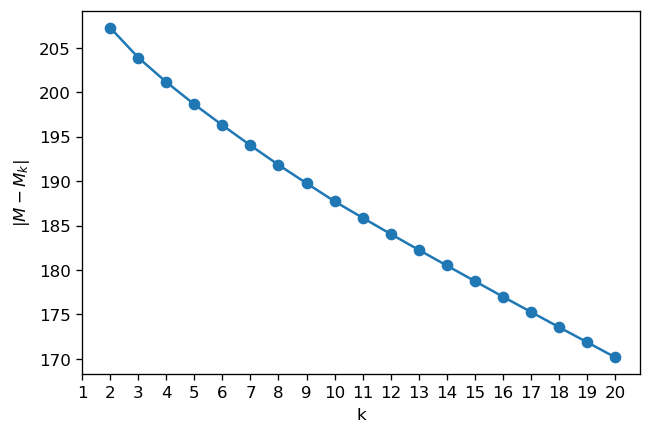

In [30]:
U,S,Vh = linalg.svd(M,compute_uv=True,full_matrices=False)
err = []
for k in range(2,21):
    Mk = U[:,:k]@np.diag(S[:k])@Vh[:k,:]
    err.append(linalg.norm(M-Mk))
plt.figure(dpi=120)
plt.plot(range(2,21),err,marker='o')
plt.xlabel('k')
plt.xticks(range(1,21))
plt.ylabel('$\|M-M_k\|$')

Dataset 2: text documents. Task: text categorization.

In [6]:
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X, axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = (eigenvector_subset.T @X_meaned.T).T
     
    return X_reduced

evansville
florida
indiana
south
miami


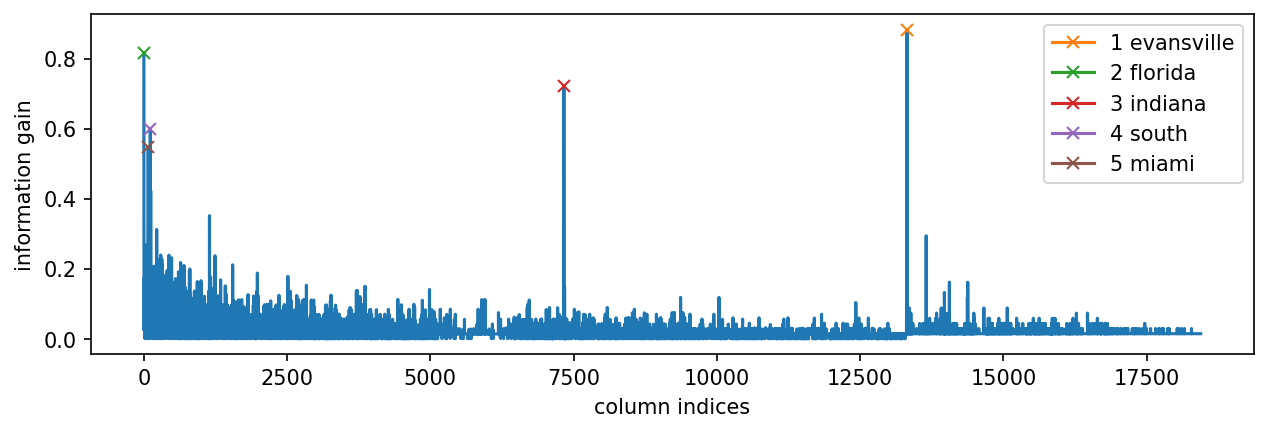

In [7]:
## information gain
n1 = (y.reshape(-1)==1).sum()
n2 = (y.reshape(-1)==-1).sum()
IG = np.absolute(M[y.reshape(-1)==1].sum(axis=0)/n1- M[y.reshape(-1)==-1].sum(axis=0)/n2)
topig_ind = np.argsort(-IG)
# plot and show top 5 words with highest information gain
plt.figure(figsize=(10,3),dpi=150)
plt.plot(IG)
for j in range(5):
    indd = topig_ind[j]
    print(words[0,indd][0])
    plt.plot(indd,IG[indd],marker='x',label='%d '%(j+1)+words[0,indd][0])
plt.legend(fontsize=10)
plt.xlabel('column indices')
plt.ylabel('information gain')
plt.show()

['evansville']
['indiana']
['contact']
['gif']
['812']
['jpg']
['florida']
['page']
['welcome']
['click']
['and']
['service']
['services']
['company']
['the']
['provide']
['miami']
['phone']
['south']
['information']


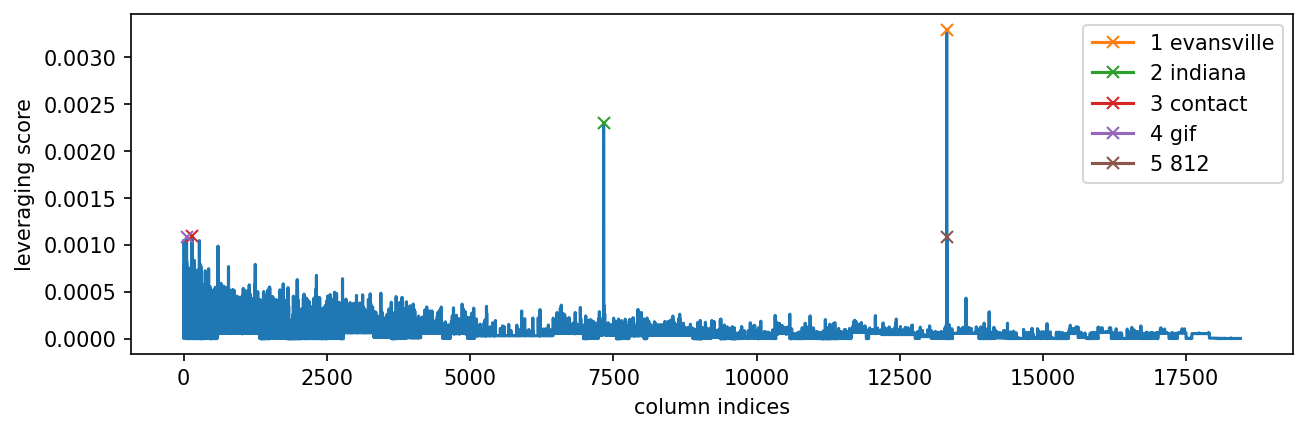

In [106]:
A = M.copy()
# A[:,topig_ind[:5]] += 1

A = M + 50*(y.T@M)/(linalg.norm(M)*linalg.norm(y))
C,cp = colSel(A,20)
for i in np.argsort(-cp)[:20]:
    print(words[0,i])
    
# plot and show top 5 words with highest information gain
plt.figure(figsize=(10,3),dpi=150)
plt.plot(cp)
for j in range(5):
    indd = np.argsort(-cp)[j]
    plt.plot(indd,cp[indd],marker='x',label='%d '%(j+1)+words[0,indd][0])
plt.legend(fontsize=10)
plt.xlabel('column indices')
plt.ylabel('leveraging score')
plt.show()

In [98]:
M.shape

(60, 20)

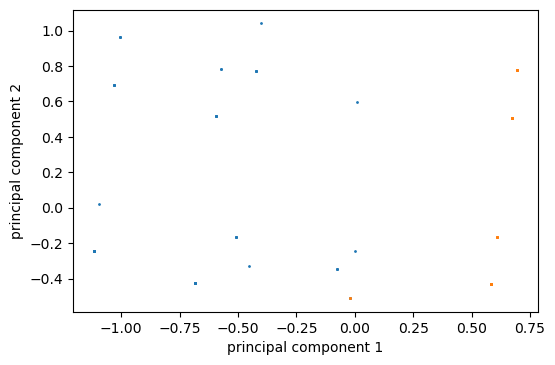

In [108]:
# C,U,R,cp,rp = CUR(M,25)
subspc = np.argsort(cp)[::-1][:5]

A = M[:,subspc]
Aproj = PCA(A,2) # return 2d array
plt.figure(dpi=100)
plt.scatter(Aproj[y.reshape(-1)==1,0], Aproj[y.reshape(-1)==1,1], s=1, label='class 1')
plt.scatter(Aproj[y.reshape(-1)==-1,0], Aproj[y.reshape(-1)==-1,1], s=1, label='class 2')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
# plt.legend()
plt.show()

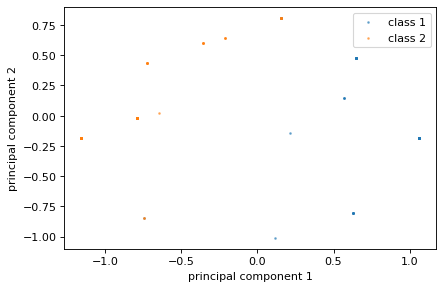

In [13]:
subspc = topig_ind[:5]
A = M[:,subspc]
Aproj = PCA(A,2) # return 2d array
plt.figure(dpi=80)
plt.scatter(Aproj[y.reshape(-1)==1,0], Aproj[y.reshape(-1)==1,1], s=2,alpha=0.5, label='class 1')
plt.scatter(Aproj[y.reshape(-1)==-1,0], Aproj[y.reshape(-1)==-1,1], s=2,alpha=0.5, label='class 2')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.legend()
plt.show()

In [36]:
print(IG[(words=='beach')[0]])
print(IG[(words=='indiana')[0]])
words[0,topig_ind[5]][0]

[0.5057995]
[0.72183099]


'beach'